<a href="https://colab.research.google.com/github/rrfsantos/Projeto-Rede-Neurais--Series-Temporais/blob/main/RedesRecorrentes_DoencasPulmonares_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Network - LSTM


## Parte 1 - Preprocessamento de Dados

### Importar as bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
np.random.seed(0)

### Importar a base de dados

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
workdir_path = '/content/drive/My Drive/Trabalho Redes Neurais/'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)

Mounted at /content/drive


In [3]:
dataset_train = pd.read_csv('train.csv')
training_set = dataset_train.iloc[:, 1:2].values #só coluna da série em si

### gráfico da série temporal

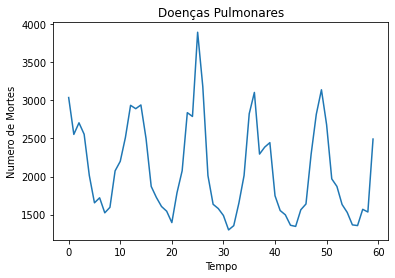

In [4]:
plt.plot(training_set)
plt.xlabel("Tempo")
plt.ylabel("Numero de Mortes")
plt.title("Doenças Pulmonares")
plt.show()

### Normalização

In [5]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 15 e output 1

In [6]:
window = 15
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [7]:
X_train.shape

(45, 15)

In [8]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [9]:
X_train.shape

(45, 15, 1)

## Parte 2 - Construção da RNN

### Construção da Rede completa

In [10]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(GRU(units = 48, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(GRU(units = 80, return_sequences = False))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
#regressor.add(LSTM(units = 50))
#regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 15, 48)            7344      
_________________________________________________________________
dropout (Dropout)            (None, 15, 48)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 80)                31200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 81        
Total params: 38,625
Trainable params: 38,625
Non-trainable params: 0
_________________________________________________________________


### Treinamento

In [11]:
regressor.fit(X_train, y_train, epochs = 500, batch_size = 32)

Epoch 1/500
2/2 [==============================] - 4s 24ms/step - loss: 0.1093
Epoch 2/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0776
Epoch 3/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0596
Epoch 4/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0643
Epoch 5/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0592
Epoch 6/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0589
Epoch 7/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0528
Epoch 8/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0481
Epoch 9/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0501
Epoch 10/500
2/2 [==============================] - 0s 25ms/step - loss: 0.0500
Epoch 11/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0522
Epoch 12/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0416
Epoch 13/500
2/2 [==============================]

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [12]:
dataset_test = pd.read_csv('test.csv')
test_pul = dataset_test.iloc[:, 1:2].values

### Construir a estrutura para teste

In [13]:
dataset_total = pd.concat((dataset_train.iloc[:,1], dataset_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [14]:
predicted = regressor.predict(X_test)
predicted = sc.inverse_transform(predicted)

### Visualizar os resultados de treino e teste

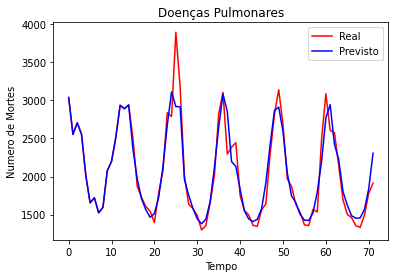

In [15]:
allTargetData = np.vstack((training_set, test_pul))
training_predicted = regressor.predict(X_train)
training_predicted = sc.inverse_transform(training_predicted)
allForecastedData = np.vstack((training_set[0:window], training_predicted, predicted))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.xlabel("Tempo")
plt.ylabel("Numero de Mortes")
plt.title("Doenças Pulmonares")
plt.legend()
plt.savefig('predictions_training_test.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [16]:
rmse = math.sqrt(mean_squared_error(test_pul, predicted))
print('RMSE: ', rmse)

RMSE:  194.65751948392472


In [17]:
mse = mean_squared_error(test_pul, predicted)
print('MSE: ',mse)

MSE:  37891.54989163453


In [18]:
mape = np.mean(np.abs((test_pul - predicted) / test_pul)) * 100
print('MAPE: ',mape, '%')

MAPE:  7.848280972351739 %


In [19]:
mae = mean_absolute_error(test_pul, predicted)
print('MAE: ',mae)

MAE:  156.87832641601562
